# **Gradient Boost from scratch**

importing the necessary libraraies

In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree

creating a dataframe

In [58]:
data = {'id':[1,1,0,1,0,0], 
        'age':[12,35,44,19,32,14],
       'deptno':[1,1,3,2,1,4],
       'block':[1,1,0,0,1,1]}  
  
 
df = pd.DataFrame(data) 

In [59]:
df.head()

,id,age,deptno,block
0,1,12,1,1
1,1,35,1,1
2,0,44,3,0
3,1,19,2,0
4,0,32,1,1


In [60]:
df.describe()

,id,age,deptno,block
count,6.000000,6.000000,6.000000,6.000000
mean,0.500000,26.000000,2.000000,0.666667
std,0.547723,12.884099,1.264911,0.516398
min,0.000000,12.000000,1.000000,0.000000
25%,0.000000,15.250000,1.000000,0.250000
50%,0.500000,25.500000,1.500000,1.000000
75%,1.000000,34.250000,2.750000,1.000000
max,1.000000,44.000000,4.000000,1.000000


**Initial Prediction**

In [61]:
df.block.value_counts()

1    4
0    2
Name: block, dtype: int64

In [62]:
log_of_odds = np.log(df.block.value_counts()[1]/ df.block.value_counts()[0])
print(log_of_odds)

0.6931471805599453


calculating prbability

In [63]:
probability = np.exp(log_of_odds)/(1+np.exp(log_of_odds))
print(probability)

0.6666666666666666


In [64]:
y_hat = np.array([probability]*6)
print(y_hat)

[0.66666667 0.66666667 0.66666667 0.66666667 0.66666667 0.66666667]


In [65]:
df['initial_pred'] = y_hat
df

,id,age,deptno,block,initial_pred
0,1,12,1,1,0.666667
1,1,35,1,1,0.666667
2,0,44,3,0,0.666667
3,1,19,2,0,0.666667
4,0,32,1,1,0.666667
5,0,14,4,1,0.666667


calculating pseudo-residuals

In [66]:
y = df.block
residuals = y - y_hat
residuals

0    0.333333
1    0.333333
2   -0.666667
3   -0.666667
4    0.333333
5    0.333333
Name: block, dtype: float64

**Building trees for perediction**

In [67]:
X = df.drop('block', axis=1)

regressor = DecisionTreeRegressor(max_depth=2) 
regressor.fit(X, residuals)

DecisionTreeRegressor(max_depth=2)

In [68]:
text_representation = tree.export_text(regressor)
print(text_representation)

|--- feature_2 <= 1.50
|   |--- value: [0.33]
|--- feature_2 >  1.50
|   |--- feature_2 <= 3.50
|   |   |--- value: [-0.67]
|   |--- feature_2 >  3.50
|   |   |--- value: [0.33]



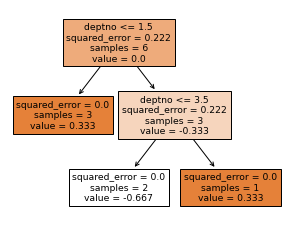

In [69]:
fig = plt.figure(figsize=(5,4))
_ = tree.plot_tree(regressor, feature_names=df.columns, filled=True)

In [70]:
reg_pred_tree1 = regressor.predict(X)/(y_hat * (1 - y_hat))
reg_pred_tree1

array([ 1.5,  1.5, -3. , -3. ,  1.5,  1.5])

In [71]:
regressor.predict(X)

array([ 0.33333333,  0.33333333, -0.66666667, -0.66666667,  0.33333333,
        0.33333333])

In [72]:
(y_hat * (1 - y_hat))

array([0.22222222, 0.22222222, 0.22222222, 0.22222222, 0.22222222,
       0.22222222])

In [73]:
lr = 0.8
log_of_odds_prediction = y_hat + 0.8 * reg_pred_tree1
log_of_odds_prediction

array([ 1.86666667,  1.86666667, -1.73333333, -1.73333333,  1.86666667,
        1.86666667])

converting to probabaility

In [74]:
def prob(pred):
    return np.exp(pred)/ (1+ np.exp(pred))


prob(1.8)

0.8581489350995122

In [75]:
vectorized_func = np.vectorize(prob)
after_tree1 = vectorized_func(log_of_odds_prediction)
after_tree1

array([0.86607211, 0.86607211, 0.15016171, 0.15016171, 0.86607211,
       0.86607211])

In [76]:
df['pred_prob'] = after_tree1
df

,id,age,deptno,block,initial_pred,pred_prob
0,1,12,1,1,0.666667,0.866072
1,1,35,1,1,0.666667,0.866072
2,0,44,3,0,0.666667,0.150162
3,1,19,2,0,0.666667,0.150162
4,0,32,1,1,0.666667,0.866072
5,0,14,4,1,0.666667,0.866072


**improving the prediction using gradient boost**

In [77]:
def gradient_boost_classification(X,y,M, lr):
    log_of_odds = np.log(y.value_counts()[1]/ y.value_counts()[0])
    probability = np.exp(log_of_odds)/(1+np.exp(log_of_odds))
    y_hat = np.array([probability]*len(y))
    
    for i in range(M):
        # calculate residuals
        residuals = y - y_hat
        # fit the tree for residuals
        regressor = DecisionTreeRegressor(max_depth=2) 
        regressor.fit(X, residuals)
        # Transformation
        reg_pred = regressor.predict(X)/(y_hat * (1 - y_hat))
        # Add the result to previous tree op
        log_of_odds_prediction = y_hat + lr * reg_pred
        new_prob = vectorized_func(log_of_odds_prediction)
        y_hat = new_prob
        
    return y_hat

In [80]:
gradient_boost_classification(X, df.block, 10, 0.8)

array([0.85698735, 0.85698735, 0.30082346, 0.30082346, 0.85698735,
       0.85698735])

In [81]:
gradient_boost_classification(X, df.block, 8,0.9)

array([0.87038976, 0.87038976, 0.27552773, 0.27552773, 0.87038976,
       0.87038976])